## 0. What I Do

- AlexNet是2012年在ILSVRC竞赛中使用的一种卷积神经网络模型，原论文中作者给出了两GPU通道并行运算的方案
- 尝试使用ImageNet2012数据集来进行复现，但是数据集规模太大，服务器塞不下，只好选择了Mini ImageNet数据集

**最后的效果不佳，可能是模型结构设计的问题**

**AlexNet 结构图**

![](https://jaggar-oss.oss-cn-shanghai.aliyuncs.com/img/20221231161147.png)

**原论文中AlexNet是使用了两个GPU并行运算实现加速的**

### 0.1 flower 数据集 20次迭代
![flower 数据集 20次迭代](./results/figures/flower_20.jpg)

## 1. 数据与预处理

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm  
import numpy as np
import sys
import json
import os

/root/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 注意改成自己的数据集路径
data_path = "/root/data/imagenet-mini/"
assert os.path.exists(data_path), "{} path does not exist.".format(data_path)

In [44]:
# 设置超参数
num_epochs = 5
batch_size = 96
learning_rate = 0.000001

In [45]:
num_workers = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # 用于加载数据集的进程数量
print('Using {} dataloader workers every process'.format(num_workers))

Using 8 dataloader workers every process


In [46]:
# CPU/GPU运行设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [54]:
data_transform = {
    "train": transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),

    "val": transforms.Compose([transforms.Resize((224, 224)),  # val不需要任何数据增强
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [48]:
# 加载训练集
train_dataset = torchvision.datasets.ImageFolder(root = os.path.join(data_path, 'train'), transform=data_transform['train'])
# 加载验证集
val_dataset = torchvision.datasets.ImageFolder(root = os.path.join(data_path, 'val'), transform=data_transform['val'])

train_num = len(train_dataset)
val_num = len(val_dataset)

In [49]:
# 配置Data loader，一次训练载入一个batch_size的数据
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print("using {} images for training, {} images for validation.".format(train_num, val_num))

using 34746 images for training, 3923 images for validation.


In [50]:
# 使用class_to_idx给类别一个index，作为训练时的标签： {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
print(flower_list)

{'n01440764': 0, 'n01443537': 1, 'n01484850': 2, 'n01491361': 3, 'n01494475': 4, 'n01496331': 5, 'n01498041': 6, 'n01514668': 7, 'n01514859': 8, 'n01518878': 9, 'n01530575': 10, 'n01531178': 11, 'n01532829': 12, 'n01534433': 13, 'n01537544': 14, 'n01558993': 15, 'n01560419': 16, 'n01580077': 17, 'n01582220': 18, 'n01592084': 19, 'n01601694': 20, 'n01608432': 21, 'n01614925': 22, 'n01616318': 23, 'n01622779': 24, 'n01629819': 25, 'n01630670': 26, 'n01631663': 27, 'n01632458': 28, 'n01632777': 29, 'n01641577': 30, 'n01644373': 31, 'n01644900': 32, 'n01664065': 33, 'n01665541': 34, 'n01667114': 35, 'n01667778': 36, 'n01669191': 37, 'n01675722': 38, 'n01677366': 39, 'n01682714': 40, 'n01685808': 41, 'n01687978': 42, 'n01688243': 43, 'n01689811': 44, 'n01692333': 45, 'n01693334': 46, 'n01694178': 47, 'n01695060': 48, 'n01697457': 49, 'n01698640': 50, 'n01704323': 51, 'n01728572': 52, 'n01728920': 53, 'n01729322': 54, 'n01729977': 55, 'n01734418': 56, 'n01735189': 57, 'n01737021': 58, 'n0173

In [51]:
# 创建一个字典，存储index和类别的对应关系，在模型推理阶段会用到。
cla_dict = dict((val, key) for key, val in flower_list.items())
print(cla_dict)

{0: 'n01440764', 1: 'n01443537', 2: 'n01484850', 3: 'n01491361', 4: 'n01494475', 5: 'n01496331', 6: 'n01498041', 7: 'n01514668', 8: 'n01514859', 9: 'n01518878', 10: 'n01530575', 11: 'n01531178', 12: 'n01532829', 13: 'n01534433', 14: 'n01537544', 15: 'n01558993', 16: 'n01560419', 17: 'n01580077', 18: 'n01582220', 19: 'n01592084', 20: 'n01601694', 21: 'n01608432', 22: 'n01614925', 23: 'n01616318', 24: 'n01622779', 25: 'n01629819', 26: 'n01630670', 27: 'n01631663', 28: 'n01632458', 29: 'n01632777', 30: 'n01641577', 31: 'n01644373', 32: 'n01644900', 33: 'n01664065', 34: 'n01665541', 35: 'n01667114', 36: 'n01667778', 37: 'n01669191', 38: 'n01675722', 39: 'n01677366', 40: 'n01682714', 41: 'n01685808', 42: 'n01687978', 43: 'n01688243', 44: 'n01689811', 45: 'n01692333', 46: 'n01693334', 47: 'n01694178', 48: 'n01695060', 49: 'n01697457', 50: 'n01698640', 51: 'n01704323', 52: 'n01728572', 53: 'n01728920', 54: 'n01729322', 55: 'n01729977', 56: 'n01734418', 57: 'n01735189', 58: 'n01737021', 59: 'n

In [52]:
# 将字典写成一个json文件
json_str = json.dumps(cla_dict, indent=4)
with open( os.path.join(data_path, 'class_indices.json') , 'w') as json_file:
    json_file.write(json_str)
json_str

'{\n    "0": "n01440764",\n    "1": "n01443537",\n    "2": "n01484850",\n    "3": "n01491361",\n    "4": "n01494475",\n    "5": "n01496331",\n    "6": "n01498041",\n    "7": "n01514668",\n    "8": "n01514859",\n    "9": "n01518878",\n    "10": "n01530575",\n    "11": "n01531178",\n    "12": "n01532829",\n    "13": "n01534433",\n    "14": "n01537544",\n    "15": "n01558993",\n    "16": "n01560419",\n    "17": "n01580077",\n    "18": "n01582220",\n    "19": "n01592084",\n    "20": "n01601694",\n    "21": "n01608432",\n    "22": "n01614925",\n    "23": "n01616318",\n    "24": "n01622779",\n    "25": "n01629819",\n    "26": "n01630670",\n    "27": "n01631663",\n    "28": "n01632458",\n    "29": "n01632777",\n    "30": "n01641577",\n    "31": "n01644373",\n    "32": "n01644900",\n    "33": "n01664065",\n    "34": "n01665541",\n    "35": "n01667114",\n    "36": "n01667778",\n    "37": "n01669191",\n    "38": "n01675722",\n    "39": "n01677366",\n    "40": "n01682714",\n    "41": "n01685808",

## 2. AlexNet结构搭建

In [65]:
# 原论文使用 2 个GPU并行运算，这里只用 1 个GPU，因此对通道数*2
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, init_weights=False):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48 * 2, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
                        
            nn.Conv2d(48 * 2, 128 * 2, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(128 * 2, 192 * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(192 * 2, 192 * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(192 * 2, 128 * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            # nn.Dropout(p = 0.5),
            nn.Linear(256 * 6 * 6, 2048 * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.4),
                        
            # nn.Dropout(p = 0.5),
            nn.Linear(2048 * 2, 2048 * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.4),
                        
            nn.Linear(2048 * 2, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [66]:
model = AlexNet().to(device)

## 3. 损失函数与优化器

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 0.0005)

## 4. 模型训练与测试

In [56]:
save_path = os.path.abspath(os.path.join(os.getcwd(), './results/weights/ImageNet_mini/'))   #os.getcwd()返回当前目录
if not os.path.exists(save_path):    
    os.mkdir(save_path)         #与Linux下相同语法

### 4.1. 模型训练

In [67]:
model.train()
total_step = len(train_loader)
Loss = []
# 每一次迭代
for epoch in range(num_epochs):
    # 每一批次数据集
    # tqdm是一个进度条显示器
    train_bar = tqdm(train_loader, file=sys.stdout, ncols=100) 
    for i, (images, labels) in enumerate(train_bar):
       
        
        images = images.to(device); labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ''' 
        if (i + 1) % 10 == 0:
            
            print("Epoch [{}/{}], Step [{}/{}], Loss: {: .4f}".format(
                epoch+1, num_epochs, i+1, total_step, loss.item())
            )
        ''' 
        Loss.append(loss.item())
        
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, num_epochs, loss)

  0%|                                                                       | 0/362 [00:22<?, ?it/s]


ValueError: expected 4D input (got 2D input)

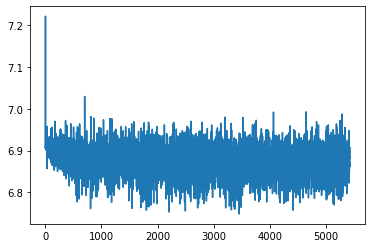

In [22]:
plt.plot(Loss)

### 4.2. 测试模型效果

In [23]:
model.eval()
pred_prob0 = []
true_label = []
val_steps = len(val_loader)
best_acc = 0
val_loss = 0.0
with torch.no_grad():
    correct = 0; total = 0
    val_bar = tqdm(train_loader, file=sys.stdout, ncols=100) 
    for i, (images, labels) in enumerate(val_bar):
        images = images.to(device); labels = labels.to(device)
        outputs = model(images)
        probs = nn.Softmax(dim=1)(outputs)
        pred_prob0.extend(probs[:,0].tolist())
        true_label.extend(labels.tolist())
        predicted = torch.max(probs, 1).indices
        # _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loss = criterion(outputs, labels)
        val_loss += loss.detach()  / (i + 1)
        val_accurate = correct / total
        # 判断当前验证集的准确率是否是最大的，如果是，则更新之前保存的权重
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(model.state_dict(), os.path.join(save_path, "AlexNet.pth") )
        if (i + 1) % 10 == 0:
            print('\n[epoch %d] val_loss: %.3f val_accuracy: %.3f' %  (i + 1, val_loss / val_steps , val_accurate))   
        
        val_loss = 0.0
    
    '''    
    print(
        "Test Accuracy of the model on the 10000 test images:{} %".format(
            100 * correct / total)
    )
    ''' 

  2%|█                                                              | 9/543 [00:14<09:26,  1.06s/it]
[epoch 10] val_loss: 0.011 val_accuracy: 0.000
  3%|██▏                                                           | 19/543 [00:24<05:07,  1.71it/s]
[epoch 20] val_loss: 0.006 val_accuracy: 0.001
  5%|███▎                                                          | 29/543 [00:27<01:39,  5.17it/s]
[epoch 30] val_loss: 0.004 val_accuracy: 0.001
  7%|████▍                                                         | 39/543 [00:36<05:20,  1.57it/s]
[epoch 40] val_loss: 0.003 val_accuracy: 0.001
  9%|█████▌                                                        | 49/543 [00:48<06:38,  1.24it/s]
[epoch 50] val_loss: 0.002 val_accuracy: 0.002
 11%|██████▋                                                       | 59/543 [00:51<03:54,  2.06it/s]
[epoch 60] val_loss: 0.002 val_accuracy: 0.002
 13%|███████▉                                                      | 69/543 [01:01<05:26,  1.45it/s]
[epoch 70] 

In [24]:
ture0 = true_label
for i, label in enumerate(true_label):
    if label == 0:
        ture0[i] = 1
    else:
        ture0[i] = 0

In [25]:
from sklearn.metrics import roc_curve, auc

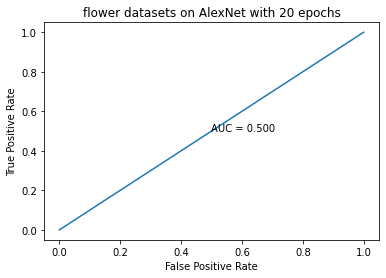

In [26]:
fpr, tpr, thresholds = roc_curve(ture0, pred_prob0)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

roc_auc = auc(fpr, tpr)
plt.text(0.5, 0.5, 'AUC = {:.3f}'.format(roc_auc))
plt.title('flower datasets on AlexNet with 20 epochs')
plt.savefig('./results/figures/flower_20.jpg')
plt.show()